# Unsupervised Capstone

In [1]:
import pandas as pd
import numpy as np
from langdetect import detect
import unicodedata as ud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

raw_data = pd.read_csv('./applestore.csv', index_col=0)
raw_data.drop(columns=['id', 'currency'], inplace=True)
print(raw_data.shape)
print(list(raw_data.columns))
raw_data.head()

(7197, 14)
['track_name', 'size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


,track_name,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
2,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
3,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
4,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
5,Bible,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [2]:
latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
        for uchr in unistr
           if uchr.isalpha())

def get_lang(x):
    if len(x.strip()) == 0:
        return None
    elif only_roman_chars(x):
        return 'Roman'
    else:
        try:
            lang = detect(x)
            if lang == 'en':
                return 'Roman'
            else:
                return 'Other'
        except:
            return None

hobby_genres = ['Sports', 'Photo & Video', 'Book', 'Games', 'Music']
lifestyle_genres = ['News', 'Lifestyle', 'Health & Fitness', 'Food & Drink', 'Shopping', 'Travel', 'Entertainment', 'Social Networking']
utility_genres = ['Productivity', 'Weather', 'Finance', 'Utilities', 'Navigation', 'Medical', 'Reference']
other_genres = ['Education', 'Business', 'Catalogs']

def get_prime_genre(genre):
    if genre in hobby_genres:
        return 'Hobby'
    elif genre in lifestyle_genres:
        return 'Lifestyle'
    elif genre in utility_genres:
        return 'Utility'
    elif genre in other_genres:
        return 'Other'

df = raw_data.copy()

df['lang'] = df['track_name'].apply(get_lang)
df['prime_genre'] = df['prime_genre'].apply(get_prime_genre)

df = df[df['prime_genre'] != 'Other']
df['prime_genre'].value_counts()

Hobby        4575
Lifestyle    1367
Utility       735
Name: prime_genre, dtype: int64

In [3]:
for col in df.columns:
    uniq_vals = len(df[col].unique())
    print(col, '-', uniq_vals, 'uniq vals')
#     if uniq_vals < 10:
#         print(df[col].value_counts(), '\n')

track_name - 6675 uniq vals
size_bytes - 6603 uniq vals
price - 33 uniq vals
rating_count_tot - 3072 uniq vals
rating_count_ver - 1119 uniq vals
user_rating - 10 uniq vals
user_rating_ver - 10 uniq vals
ver - 1540 uniq vals
cont_rating - 4 uniq vals
prime_genre - 3 uniq vals
sup_devices.num - 20 uniq vals
ipadSc_urls.num - 6 uniq vals
lang.num - 57 uniq vals
vpp_lic - 2 uniq vals
lang - 2 uniq vals


size_bytes - Avg: 201779103.11 ; Median: 96720896.0
price - Avg: 1.54 ; Median: 0.0
rating_count_tot - Avg: 13701.61 ; Median: 325.0
rating_count_ver - Avg: 477.14 ; Median: 25.0
user_rating - Avg: 3.54 ; Median: 4.0
user_rating_ver - Avg: 3.28 ; Median: 4.0
ipadSc_urls.num - Avg: 3.66 ; Median: 5.0
lang.num - Avg: 5.27 ; Median: 1.0


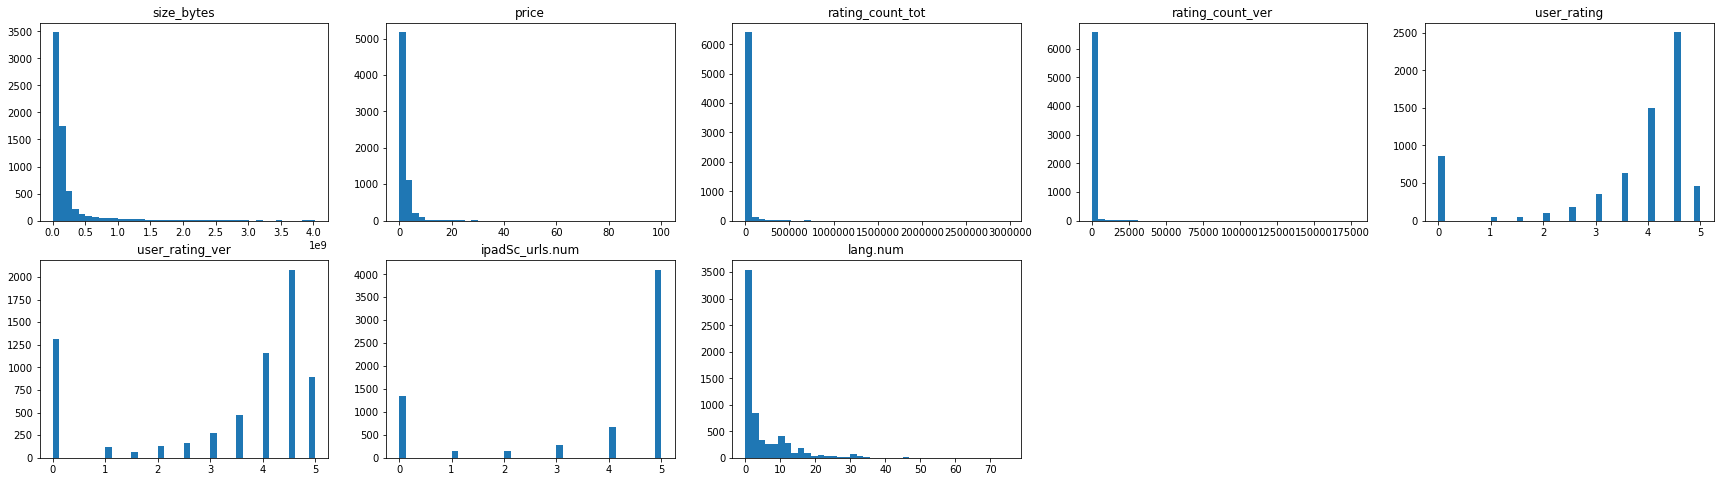

In [4]:
df['free'] = df['price'].apply(lambda x: 1 if x == 0 else 0)

# df['high_rating_count_tot'] = df['rating_count_tot'] >= df['rating_count_tot'].median()
# df['high_rating_count_ver'] = df['rating_count_ver'] >= df['rating_count_ver'].median()

df['high_rating'] = df['user_rating'] >= df['user_rating'].median()
df['high_rating_ver'] = df['user_rating_ver'] >= df['user_rating_ver'].median()

continuous_cols = ['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num', 'lang.num']

plt.figure(figsize=(30,8))

for idx, col in enumerate(continuous_cols):
    plt.subplot(2, 5, idx + 1)
    plt.hist(df[col], bins=40)
    plt.title(col)
    print(col, '- Avg:', round(df[col].mean(), 2), '; Median:', round(df[col].median(), 2))

plt.show()

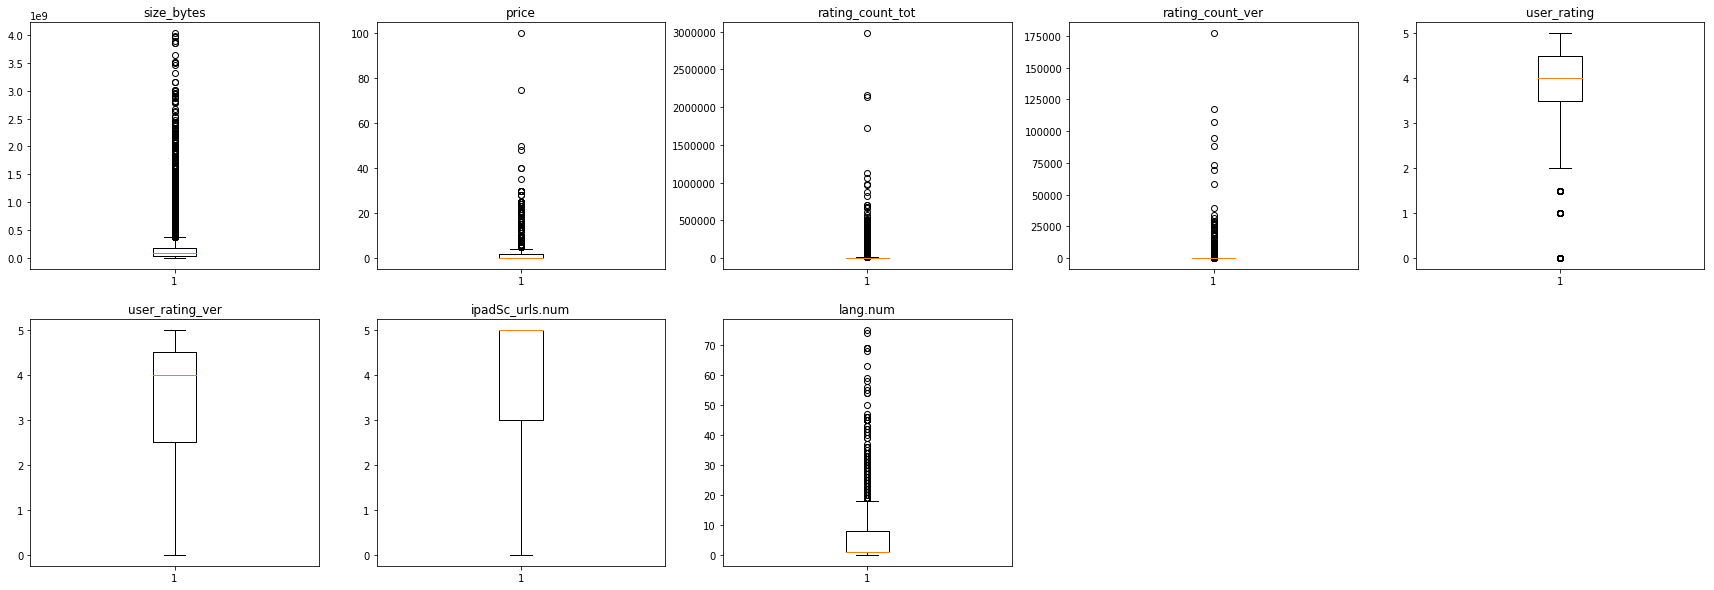

In [5]:
plt.figure(figsize=(30,10))

for idx, col in enumerate(continuous_cols):
    plt.subplot(2, 5, idx + 1)
    plt.boxplot(df[col])
    plt.title(col)

plt.show()

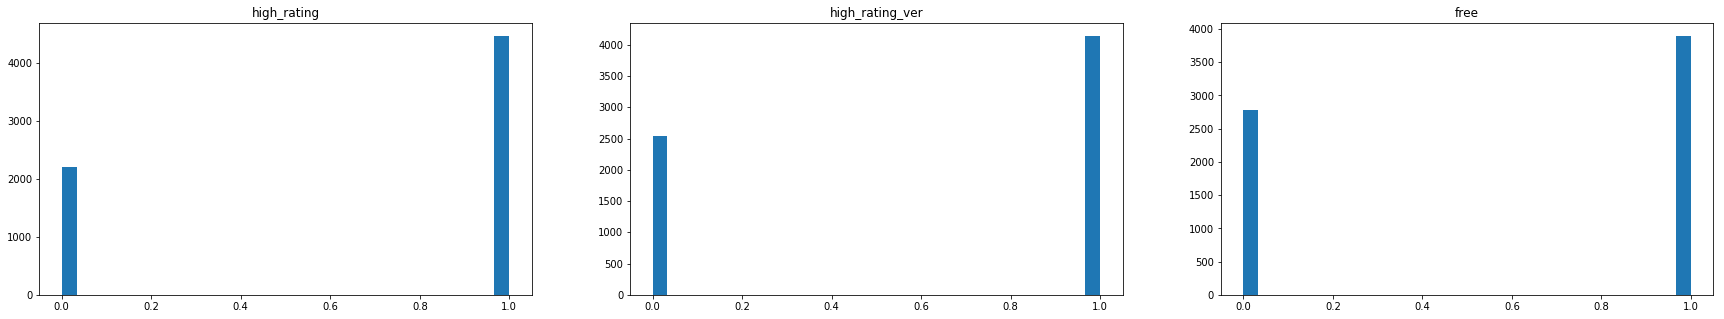

In [6]:
categ_cols = ['high_rating', 'high_rating_ver', 'free']
# , 'high_rating_count_tot', 'high_rating_count_ver']

plt.figure(figsize=(30,5))

for idx, col in enumerate(categ_cols):
    plt.subplot(1, 3, idx + 1)
    plt.hist(df[col], bins=30)
    plt.title(col)

plt.show()

In [7]:
# df['size_small'] = df['size_bytes'].apply(lambda x: 1 if x <= df['size_bytes'].median() else 0)
df['major_v'] = df['ver'].str.extract('(\d+)', expand=False).str.split('.').apply(lambda x:x[0])
df['major_v'] = pd.to_numeric(df['major_v'], errors='coerce').fillna(0).astype(np.int64)

df['up_to_v_1'] = df['major_v'].apply(lambda x: 1 if x <= 1 else 0)

df.drop(columns=['ver', 'major_v'], inplace=True)
df.head()

,track_name,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,lang,free,high_rating,high_rating_ver,up_to_v_1
1,PAC-MAN Premium,100788224,3.99,21292,26,4.0,4.5,4+,Hobby,38,5,10,1,Roman,0,True,True,0
2,Evernote - stay organized,158578688,0.00,161065,26,4.0,3.5,4+,Utility,37,5,23,1,Roman,1,True,False,0
3,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,2822,3.5,4.5,4+,Utility,37,5,3,1,Roman,1,False,True,0
4,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,649,4.0,4.5,12+,Lifestyle,37,5,9,1,Roman,1,True,True,0
5,Bible,92774400,0.00,985920,5320,4.5,5.0,4+,Utility,37,5,45,1,Roman,1,True,True,0


In [8]:
cols_to_dummify = ['cont_rating', 'prime_genre', 'vpp_lic', 'high_rating', 'high_rating_ver', 'up_to_v_1', 'lang']
# 'high_rating_count_tot', 'high_rating_count_ver', 'size_small'

for col in cols_to_dummify:
    dummies = pd.get_dummies(df[col])
    for dummy in dummies:
        df[col + '_' + str(dummy)] = dummies[dummy]
    
df.drop(columns=cols_to_dummify, inplace=True)
df.drop(columns=['track_name', 'vpp_lic_0', 'vpp_lic_1', 'sup_devices.num', 'lang_Other', 'lang_Roman'], inplace=True)   
df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ipadSc_urls.num,lang.num,free,cont_rating_12+,...,cont_rating_9+,prime_genre_Hobby,prime_genre_Lifestyle,prime_genre_Utility,high_rating_False,high_rating_True,high_rating_ver_False,high_rating_ver_True,up_to_v_1_0,up_to_v_1_1
1,100788224,3.99,21292,26,4.0,4.5,5,10,0,0,...,0,1,0,0,0,1,0,1,1,0
2,158578688,0.00,161065,26,4.0,3.5,5,23,1,0,...,0,0,0,1,0,1,1,0,1,0
3,100524032,0.00,188583,2822,3.5,4.5,5,3,1,0,...,0,0,0,1,1,0,0,1,1,0
4,128512000,0.00,262241,649,4.0,4.5,5,9,1,1,...,0,0,1,0,0,1,0,1,1,0
5,92774400,0.00,985920,5320,4.5,5.0,5,45,1,0,...,0,0,0,1,0,1,0,1,1,0


In [9]:
cols_to_norm = continuous_cols

# Normalize data before clustering
df = df.dropna(subset=cols_to_norm)

cluster_df = df.copy()
cluster_df[cols_to_norm] = normalize(cluster_df[cols_to_norm])
    
cluster_df = pd.concat([cluster_df[cols_to_norm], cluster_df[cluster_df.columns.difference(cols_to_norm)]], axis=1)
print(cluster_df.shape[0], 'rows;', cluster_df.shape[1], 'columns')

print(list(cluster_df.columns))
cluster_df.head()

6677 rows; 22 columns
['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num', 'lang.num', 'cont_rating_12+', 'cont_rating_17+', 'cont_rating_4+', 'cont_rating_9+', 'free', 'high_rating_False', 'high_rating_True', 'high_rating_ver_False', 'high_rating_ver_True', 'prime_genre_Hobby', 'prime_genre_Lifestyle', 'prime_genre_Utility', 'up_to_v_1_0', 'up_to_v_1_1']


,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ipadSc_urls.num,lang.num,cont_rating_12+,cont_rating_17+,...,free,high_rating_False,high_rating_True,high_rating_ver_False,high_rating_ver_True,prime_genre_Hobby,prime_genre_Lifestyle,prime_genre_Utility,up_to_v_1_0,up_to_v_1_1
1,1.000000,3.958796e-08,0.000211,2.579666e-07,3.968718e-08,4.464807e-08,4.960897e-08,9.921794e-08,0,0,...,0,0,1,0,1,1,0,0,1,0
2,0.999999,0.000000e+00,0.001016,1.639564e-07,2.522406e-08,2.207105e-08,3.153007e-08,1.450383e-07,0,0,...,1,0,1,1,0,0,0,1,1,0
3,0.999998,0.000000e+00,0.001876,2.807284e-05,3.481748e-08,4.476534e-08,4.973926e-08,2.984356e-08,0,0,...,1,1,0,0,1,0,0,1,1,0
4,0.999998,0.000000e+00,0.002041,5.050102e-06,3.112543e-08,3.501611e-08,3.890679e-08,7.003222e-08,1,0,...,1,0,1,0,1,0,1,0,1,0
5,0.999944,0.000000e+00,0.010626,5.734017e-05,4.850202e-08,5.389113e-08,5.389113e-08,4.850202e-07,0,0,...,1,0,1,0,1,0,0,1,1,0


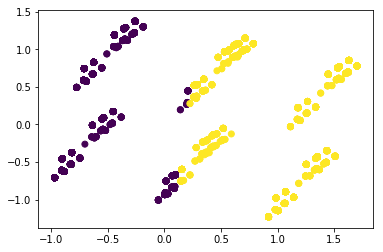

In [10]:
pca_2 = PCA(2).fit_transform(cluster_df)
kmeans_2_pred = KMeans(n_clusters=2, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_2_pred)
plt.show()

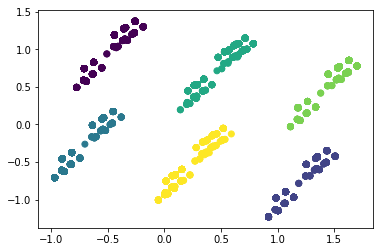

In [11]:
kmeans_6_pred = KMeans(n_clusters=6, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_6_pred)
plt.show()

Comparing k-means and mini batch k-means solutions:
col_0     0    1     2    3    4    5
row_0                                
0         0    0  2297    0    0    0
1         0    0     0  557    0    0
2         0  807     0    0    0  414
3         0    0     0    0  451    0
4         0  355     0    0  264   17
5      1515    0     0    0    0    0


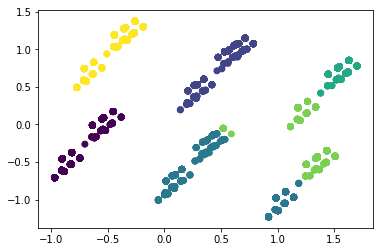

In [12]:
minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=6, batch_size=200)
minibatchkmeans.fit(pca_2)

# Add the new predicted cluster memberships to the data frame.
mini_pred = minibatchkmeans.predict(pca_2)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(mini_pred, kmeans_6_pred))

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=mini_pred)
plt.show()

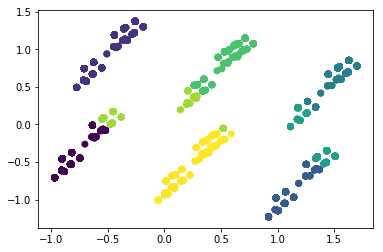

In [13]:
bandwidth = estimate_bandwidth(pca_2, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_pred = ms.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=ms_pred)
plt.show()

In [14]:
df['kmeans_6_pred'] = kmeans_6_pred

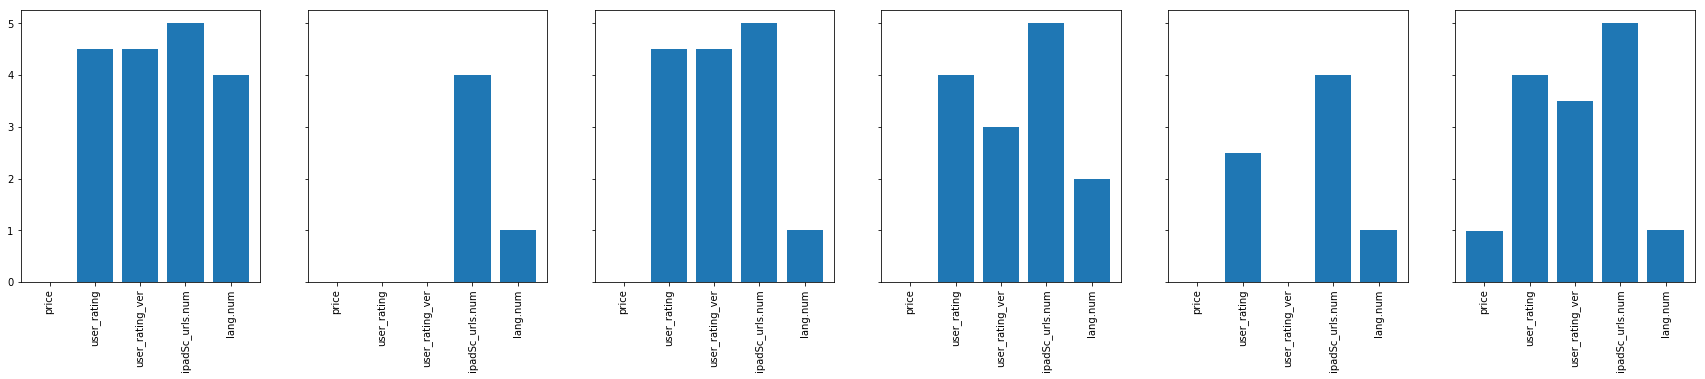

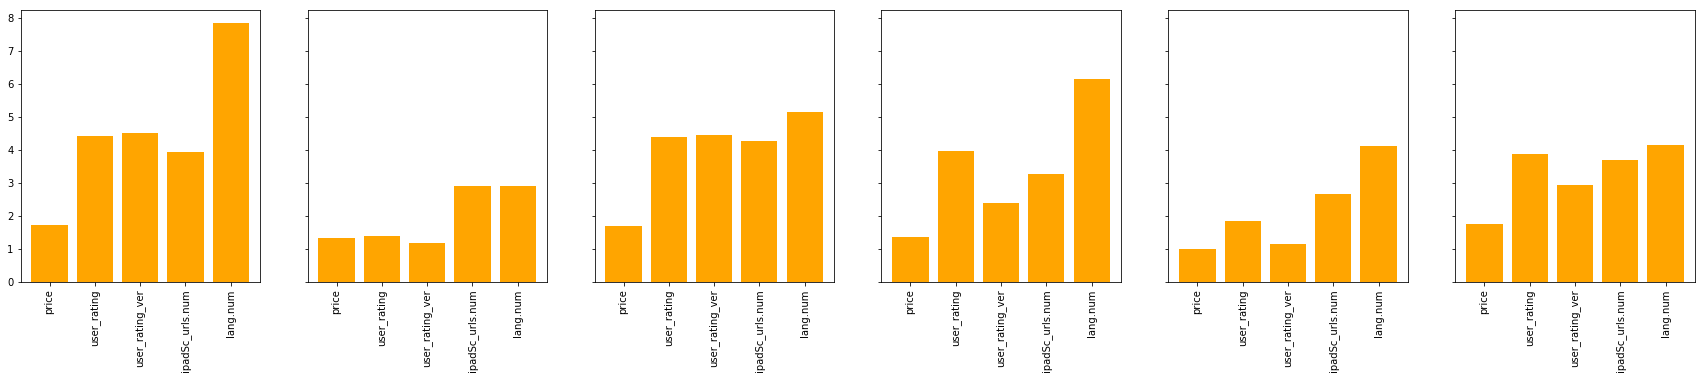

In [15]:
cluster_1 = df[df['kmeans_6_pred'] == 0].loc[:, df.columns != 'kmeans_6_pred']
cluster_2 = df[df['kmeans_6_pred'] == 1].loc[:, df.columns != 'kmeans_6_pred']
cluster_3 = df[df['kmeans_6_pred'] == 2].loc[:, df.columns != 'kmeans_6_pred']
cluster_4 = df[df['kmeans_6_pred'] == 3].loc[:, df.columns != 'kmeans_6_pred']
cluster_5 = df[df['kmeans_6_pred'] == 4].loc[:, df.columns != 'kmeans_6_pred']
cluster_6 = df[df['kmeans_6_pred'] == 5].loc[:, df.columns != 'kmeans_6_pred']
all_clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]

# MEDIANS
clusters_medians_df = pd.DataFrame()
for idx, cluster in enumerate(all_clusters):
    for col in cluster.columns:
        clusters_medians_df.at[idx, col] = cluster[col].median()

cols_to_compare = ['price', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num', 'lang.num']

f, axes = plt.subplots(1, 6, sharey=True, figsize=(30, 5))

for rowIdx in range(6):
    cluster = clusters_medians_df.iloc[rowIdx,:]
    axes[rowIdx].bar(cluster[cols_to_compare].index, height=cluster[cols_to_compare])

    for tick in axes[rowIdx].get_xticklabels():
        tick.set_rotation(90)
    
plt.show()

# MEANS
clusters_means_df = pd.DataFrame()
for idx, cluster in enumerate(all_clusters):
    for col in cluster.columns:
        clusters_means_df.at[idx, col] = cluster[col].mean()

cols_to_compare = ['price', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num', 'lang.num']

f, axes = plt.subplots(1, 6, sharey=True, figsize=(30, 5))

for rowIdx in range(6):
    cluster = clusters_means_df.iloc[rowIdx,:]
    axes[rowIdx].bar(cluster[cols_to_compare].index, height=cluster[cols_to_compare], color='orange')

    for tick in axes[rowIdx].get_xticklabels():
        tick.set_rotation(90)
    
plt.show()

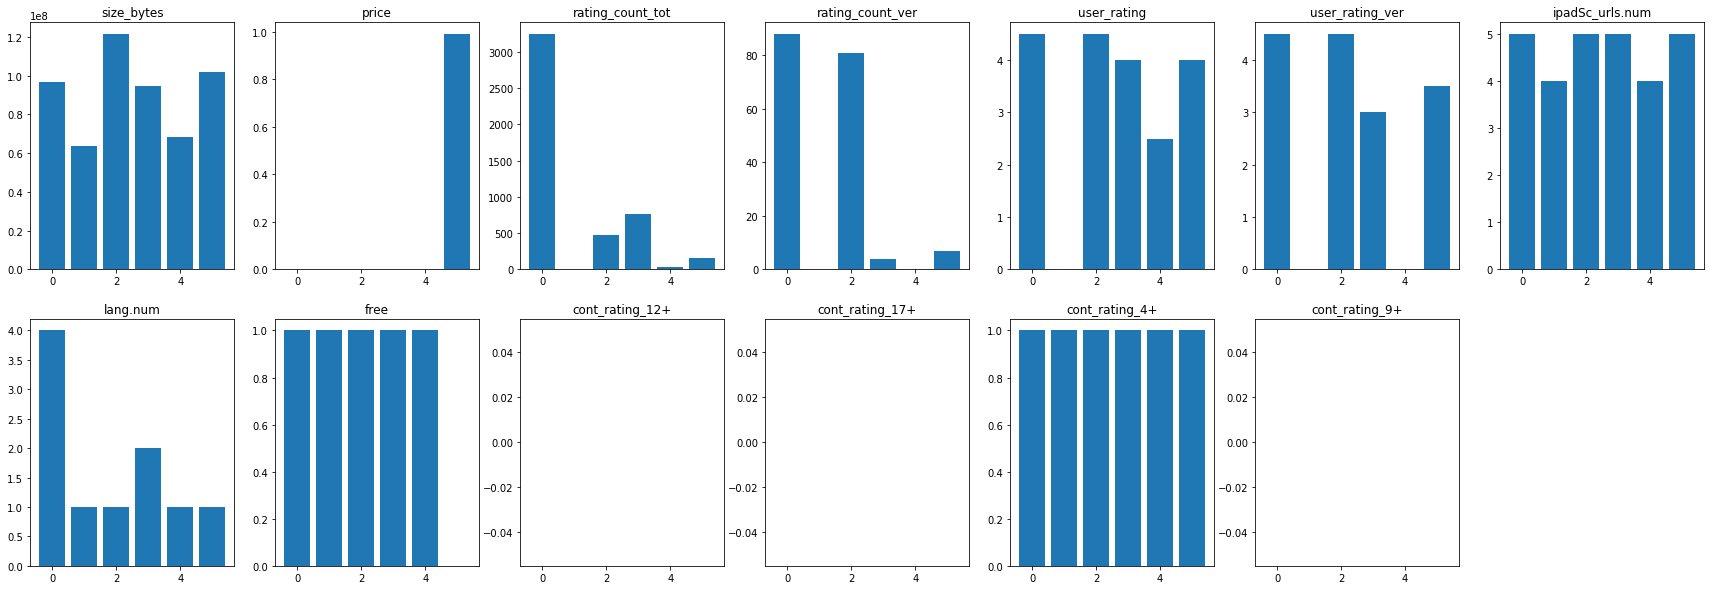

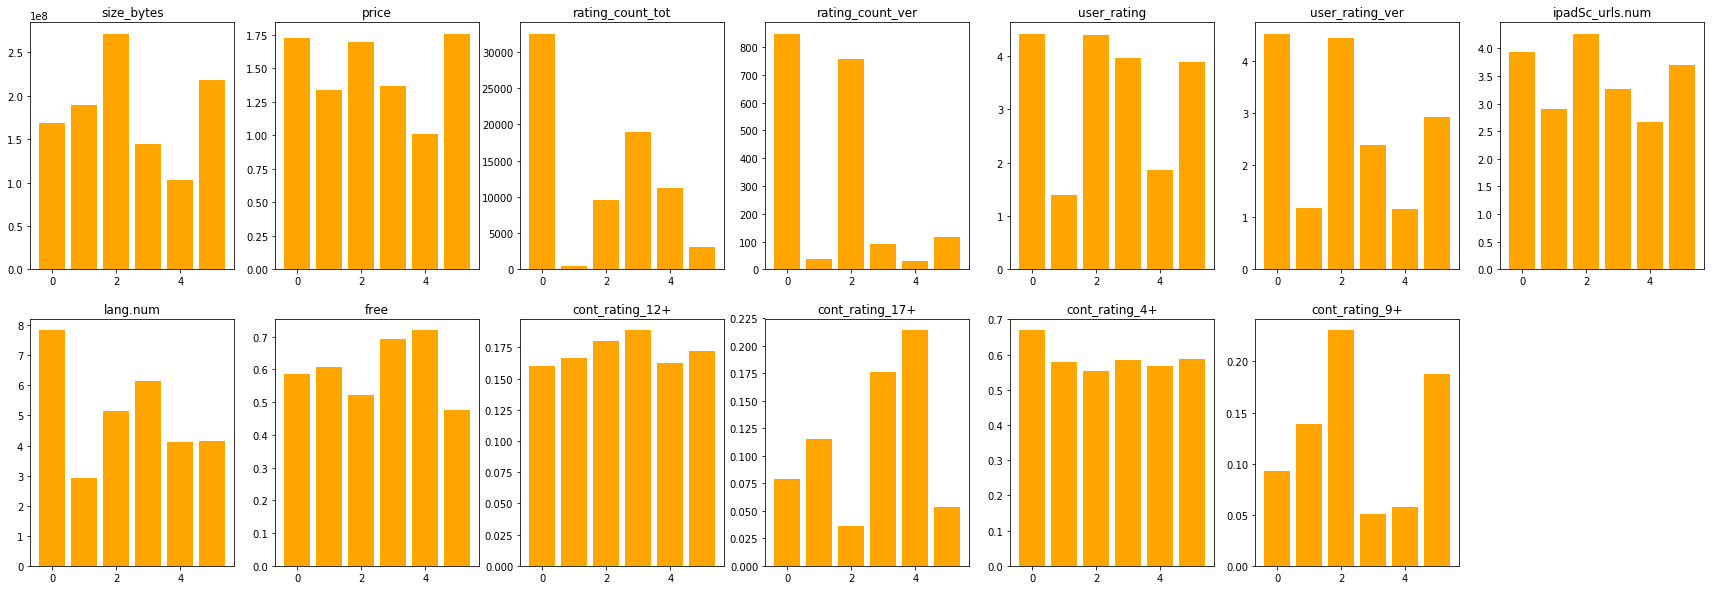

In [16]:
# MEDIANS
plt.figure(figsize=(30,10))

cols_1 = ['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num',
       'lang.num', 'free', 'cont_rating_12+', 'cont_rating_17+', 'cont_rating_4+', 'cont_rating_9+']

for idx, col in enumerate(cols_1):
    plt.subplot(2, 7, idx + 1)
    plt.bar(clusters_medians_df.index, height=clusters_medians_df[col])
    plt.title(col)
plt.show()

# MEANS
plt.figure(figsize=(30,10))

for idx, col in enumerate(cols_1):
    plt.subplot(2, 7, idx + 1)
    plt.bar(clusters_means_df.index, height=clusters_means_df[col], color='orange')
    plt.title(col)
plt.show()

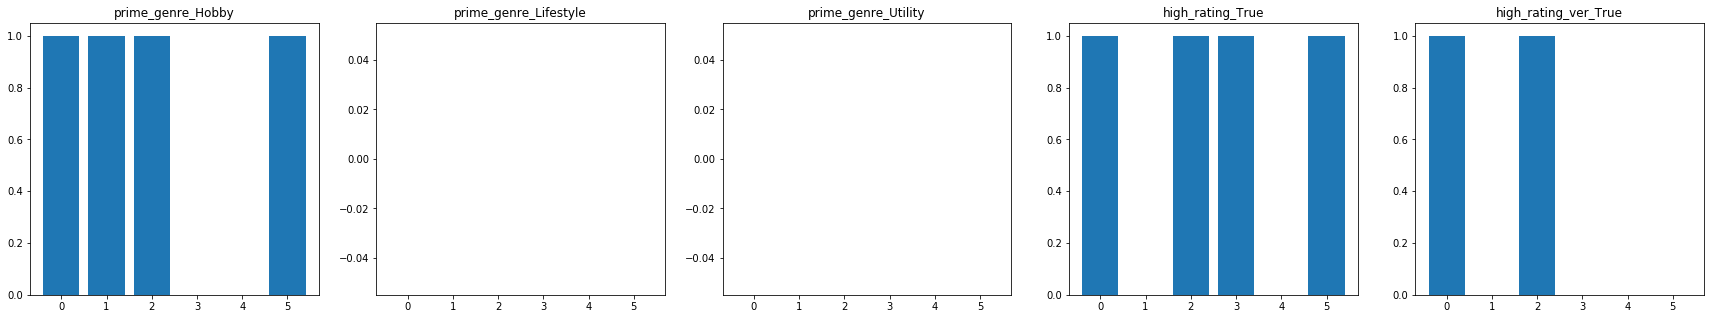

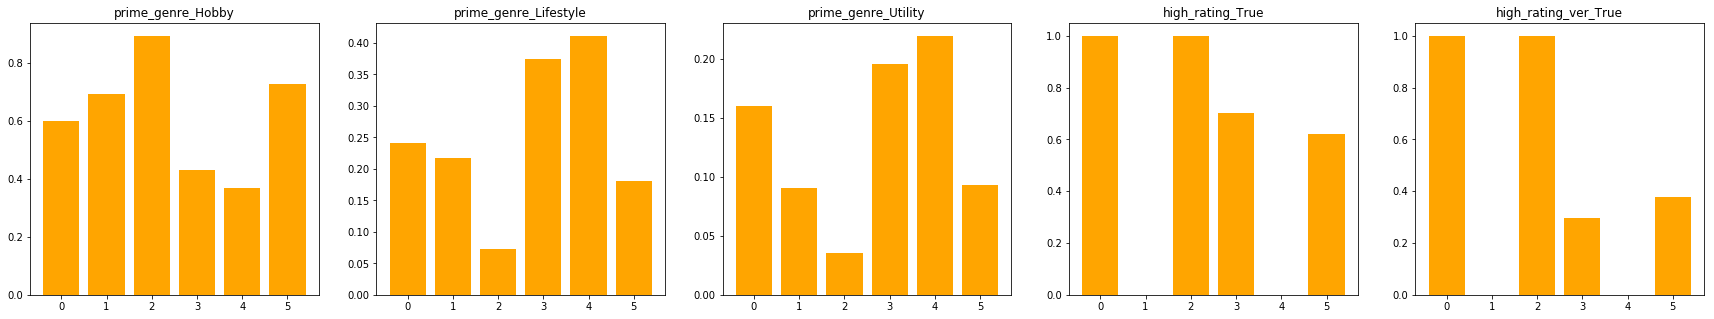

In [18]:
cols_2 = ['prime_genre_Hobby', 'prime_genre_Lifestyle', 'prime_genre_Utility', 'high_rating_True', 'high_rating_ver_True']

# MEDIANS
plt.figure(figsize=(30,5))

for idx, col in enumerate(cols_2):
    plt.subplot(1, 5, idx + 1)
    plt.bar(clusters_medians_df.index, height=clusters_medians_df[col])
    plt.title(col)
plt.show()

# MEANS
plt.figure(figsize=(30,5))

for idx, col in enumerate(cols_2):
    plt.subplot(1, 5, idx + 1)
    plt.bar(clusters_means_df.index, height=clusters_means_df[col], color='orange')
    plt.title(col)
plt.show()

In [19]:
clusters_medians_df

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ipadSc_urls.num,lang.num,free,cont_rating_12+,...,cont_rating_9+,prime_genre_Hobby,prime_genre_Lifestyle,prime_genre_Utility,high_rating_False,high_rating_True,high_rating_ver_False,high_rating_ver_True,up_to_v_1_0,up_to_v_1_1
0,96992256.0,0.00,3248.0,88.0,4.5,4.5,5.0,4.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,63767552.0,0.00,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,121593856.0,0.00,474.0,81.0,4.5,4.5,5.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,94496768.0,0.00,762.0,4.0,4.0,3.0,5.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,68217856.0,0.00,32.0,0.0,2.5,0.0,4.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,102096896.0,0.99,158.0,7.0,4.0,3.5,5.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [20]:
clusters_means_df

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ipadSc_urls.num,lang.num,free,cont_rating_12+,...,cont_rating_9+,prime_genre_Hobby,prime_genre_Lifestyle,prime_genre_Utility,high_rating_False,high_rating_True,high_rating_ver_False,high_rating_ver_True,up_to_v_1_0,up_to_v_1_1
0,1.689035e+08,1.723914,32461.529373,847.361716,4.413861,4.521452,3.941254,7.826403,0.586139,0.160396,...,0.092409,0.598680,0.241584,0.159736,0.000000,1.000000,0.000000,1.000000,1.0,0.0
1,1.897887e+08,1.336859,481.525818,36.611015,1.387263,1.185456,2.908778,2.909639,0.606713,0.166093,...,0.138554,0.691910,0.217728,0.090361,1.000000,0.000000,1.000000,0.000000,0.0,1.0
2,2.711462e+08,1.695690,9534.470178,755.421855,4.400522,4.448629,4.259034,5.141924,0.521114,0.180235,...,0.230300,0.891598,0.072704,0.035699,0.000000,1.000000,0.000000,1.000000,0.0,1.0
3,1.439584e+08,1.368564,18881.958707,92.050269,3.972172,2.396768,3.263914,6.149013,0.692998,0.188510,...,0.050269,0.429084,0.375224,0.195691,0.298025,0.701975,0.701975,0.298025,1.0,0.0
4,1.030968e+08,1.006979,11206.485315,31.174825,1.856643,1.154545,2.669930,4.130070,0.718881,0.162238,...,0.057343,0.369231,0.411189,0.219580,1.000000,0.000000,1.000000,0.000000,1.0,0.0
5,2.184079e+08,1.755777,3054.106729,117.948956,3.880510,2.925754,3.689095,4.155452,0.475638,0.171694,...,0.187935,0.726218,0.180974,0.092807,0.378190,0.621810,0.621810,0.378190,0.0,1.0


In [21]:
for col in clusters_medians_df:
    print(col)
    for group in range(6):
        mean = round(clusters_means_df.iloc[group][col], 2)
        med = round(clusters_medians_df.iloc[group][col], 2)
        print('   Group', group + 1, '– Avg:', mean, 'Median:', med)

size_bytes
   Group 1 – Avg: 168903513.73 Median: 96992256.0
   Group 2 – Avg: 189788738.88 Median: 63767552.0
   Group 3 – Avg: 271146216.42 Median: 121593856.0
   Group 4 – Avg: 143958438.1 Median: 94496768.0
   Group 5 – Avg: 103096829.35 Median: 68217856.0
   Group 6 – Avg: 218407868.87 Median: 102096896.0
price
   Group 1 – Avg: 1.72 Median: 0.0
   Group 2 – Avg: 1.34 Median: 0.0
   Group 3 – Avg: 1.7 Median: 0.0
   Group 4 – Avg: 1.37 Median: 0.0
   Group 5 – Avg: 1.01 Median: 0.0
   Group 6 – Avg: 1.76 Median: 0.99
rating_count_tot
   Group 1 – Avg: 32461.53 Median: 3248.0
   Group 2 – Avg: 481.53 Median: 0.0
   Group 3 – Avg: 9534.47 Median: 474.0
   Group 4 – Avg: 18881.96 Median: 762.0
   Group 5 – Avg: 11206.49 Median: 32.0
   Group 6 – Avg: 3054.11 Median: 158.0
rating_count_ver
   Group 1 – Avg: 847.36 Median: 88.0
   Group 2 – Avg: 36.61 Median: 0.0
   Group 3 – Avg: 755.42 Median: 81.0
   Group 4 – Avg: 92.05 Median: 4.0
   Group 5 – Avg: 31.17 Median: 0.0
   Group 6 – A

## Conclusion

Looking at the 6 clusters that appear in my data, I can start differentiating them from each other based on the features I selected. I can roughly characterize the groups as such: 

- Group 1 
    - Infrequently & Highly Rated
    - Affordable
    - Large
    - Hobby & Lifestyle Apps
- Group 2 
    - Infrequently & Lowly Rated
    - Mostly Free
    - Smallest
    - Most Age-Restricted
    - Social & Utility Apps
- Group 3 
    - Frequently & Highly Rated
    - Most Multi-Language
    - Most Age-Inclusive 
    - Utility Apps
- Group 4 
    - Mid-Rated Lifestyle Apps
- Group 5 
    - Frequently & Lowly Rated
    - Mostly Free
    - Smallest
    - Lifestyle Apps
- Group 6 
    - Infrequently & Mid-Rated
    - Expensive
    - Large
    - Hobby Apps